In [187]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import datetime as dt
sns.set_theme()

In [188]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error

In [189]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [190]:
import geopy
from geopy.geocoders import Nominatim

In [191]:
data=pd.read_csv("/Users/mihailkozlov/Downloads/all_v2.csv")

In [192]:
#названия регионов даны в виде кодов,очертим примерные границы Краснодарского края
#видно, что чаще всего встречается код 2843 -> это код Краснодарского края
data[(data["geo_lat"]<47) & (data["geo_lat"]>44) & (data["geo_lon"]>36) & (data["geo_lon"]<42)].region.value_counts()

2843     569695
2900      31862
11416      5243
11991       470
3230        366
6937        239
8509         48
Name: region, dtype: int64

In [193]:
data_krasnodar=data[data.region==2843].drop("region",axis=1)

In [194]:
#Удалим дубликаты
data_krasnodar.drop_duplicates(inplace=True)

In [195]:
#получили данные исключительно по Краснодарскому краю
data_krasnodar

,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,4,12,16,2,38.0,5.0,11
19,1650000,2018-03-16,16:21:54,44.994301,41.122810,3,5,5,2,51.0,7.0,1
32,2500000,2018-04-04,19:37:22,43.634694,39.727167,2,2,8,-1,25.0,5.0,1
46,2600000,2018-04-23,09:53:29,45.003174,39.079931,4,3,5,2,46.0,8.0,1
50,2220000,2018-04-25,09:22:20,45.002575,39.083183,3,2,18,1,49.5,16.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,2021-05-01,19:51:43,44.720695,37.762310,2,18,22,1,42.0,16.0,1
5476930,7500000,2021-05-01,20:00:43,44.895043,37.316328,2,16,17,1,44.0,14.0,11
5476943,2700000,2021-05-01,20:03:41,45.102430,39.033975,2,8,17,1,34.0,10.0,1
5476990,5800000,2021-05-01,20:12:44,45.085553,39.044627,2,1,16,2,61.0,12.0,11


In [196]:
#следует избавитьс от колонки с кол-вом комант, поскольку между этими признаками сильная корреляция
data.area.corr(data.rooms,method="spearman")

0.8118058161379311

In [197]:
data_krasnodar.drop("rooms",axis=1,inplace=True)

In [198]:
#также стоит избавиться от признака времени публикации объявления
data_krasnodar.drop("time",axis=1,inplace=True)

In [199]:
#площадь кухни выкидывать не будем из-за слабой корреляции между ней и площадью всей квартиры
data_krasnodar.kitchen_area.corr(data.area)

0.23123344225719408

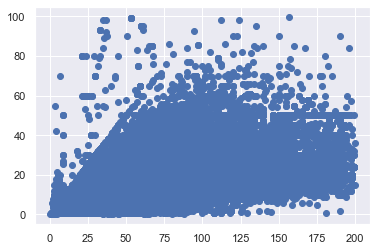

In [200]:
plt.scatter(data_krasnodar[(data_krasnodar.area<200) & (data_krasnodar.kitchen_area<100)].area,data_krasnodar[(data_krasnodar.area<200) & (data_krasnodar.kitchen_area<100)].kitchen_area)

In [201]:
data_krasnodar

,price,date,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type
3,1850000,2018-03-01,44.996132,39.074783,4,12,16,38.0,5.0,11
19,1650000,2018-03-16,44.994301,41.122810,3,5,5,51.0,7.0,1
32,2500000,2018-04-04,43.634694,39.727167,2,2,8,25.0,5.0,1
46,2600000,2018-04-23,45.003174,39.079931,4,3,5,46.0,8.0,1
50,2220000,2018-04-25,45.002575,39.083183,3,2,18,49.5,16.4,1
...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,2021-05-01,44.720695,37.762310,2,18,22,42.0,16.0,1
5476930,7500000,2021-05-01,44.895043,37.316328,2,16,17,44.0,14.0,11
5476943,2700000,2021-05-01,45.102430,39.033975,2,8,17,34.0,10.0,1
5476990,5800000,2021-05-01,45.085553,39.044627,2,1,16,61.0,12.0,11


In [202]:
#очевидно, что дата выставления объявления почти никак не влияет на цену, поэтому надо сделать 2: признака год и
# месяц выставления объявления
data_krasnodar["year"]=pd.DatetimeIndex(data_krasnodar.date).year
data_krasnodar["month"]=pd.DatetimeIndex(data_krasnodar.date).month
data_krasnodar.drop("date",axis=1,inplace=True)

In [203]:
data_krasnodar

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month
3,1850000,44.996132,39.074783,4,12,16,38.0,5.0,11,2018,3
19,1650000,44.994301,41.122810,3,5,5,51.0,7.0,1,2018,3
32,2500000,43.634694,39.727167,2,2,8,25.0,5.0,1,2018,4
46,2600000,45.003174,39.079931,4,3,5,46.0,8.0,1,2018,4
50,2220000,45.002575,39.083183,3,2,18,49.5,16.4,1,2018,4
...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.720695,37.762310,2,18,22,42.0,16.0,1,2021,5
5476930,7500000,44.895043,37.316328,2,16,17,44.0,14.0,11,2021,5
5476943,2700000,45.102430,39.033975,2,8,17,34.0,10.0,1,2021,5
5476990,5800000,45.085553,39.044627,2,1,16,61.0,12.0,11,2021,5


In [204]:
from math import sqrt
anap_lat=44.8
anap_lon=37.3
gel_lat=44.5
gel_lon=38
tuap_lat=44
tuap_lon=39
soch_lat=43.5
soch_lon=39.7
#добавление параметра - удаленность от моря, 1 градус примерно равен 111 км, в качестве расстояния возьмем минимум из расстояний до Геленджика, Анапы, Туапсе или Сочи
data_krasnodar['to_anap']=111*((data_krasnodar.geo_lat-anap_lat)**2+(data_krasnodar.geo_lon-anap_lon)**2)
data_krasnodar['to_gel']=111*((data_krasnodar.geo_lat-gel_lat)**2+(data_krasnodar.geo_lon-gel_lon)**2)
data_krasnodar['to_tuap']=111*((data_krasnodar.geo_lat-tuap_lat)**2+(data_krasnodar.geo_lon-tuap_lon)**2)
data_krasnodar['to_soch']=111*((data_krasnodar.geo_lat-soch_lat)**2+(data_krasnodar.geo_lon-soch_lon)**2)

In [205]:
l=data_krasnodar[['to_anap','to_gel','to_soch','to_tuap']]

In [206]:
data_krasnodar['to_sea']=l.min(axis=1)

In [207]:
data_krasnodar.drop(l.columns,axis=1,inplace=True)

In [208]:
data_krasnodar

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea
3,1850000,44.996132,39.074783,4,12,16,38.0,5.0,11,2018,3,110.763732
19,1650000,44.994301,41.122810,3,5,5,51.0,7.0,1,2018,3,472.563100
32,2500000,43.634694,39.727167,2,2,8,25.0,5.0,1,2018,4,2.095738
46,2600000,45.003174,39.079931,4,3,5,46.0,8.0,1,2018,4,112.414921
50,2220000,45.002575,39.083183,3,2,18,49.5,16.4,1,2018,4,112.340441
...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.720695,37.762310,2,18,22,42.0,16.0,1,2021,5,11.677513
5476930,7500000,44.895043,37.316328,2,16,17,44.0,14.0,11,2021,5,1.032282
5476943,2700000,45.102430,39.033975,2,8,17,34.0,10.0,1,2021,5,135.032264
5476990,5800000,45.085553,39.044627,2,1,16,61.0,12.0,11,2021,5,131.026296


In [209]:
#добавим критерий расстояние до аэропорта, используем данные расстояний до моря
l.drop('to_tuap',axis=1,inplace=True)

/Users/mihailkozlov/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [210]:
kr_lat=45
kr_lon=39.2
l['to_krasn']=111*((data_krasnodar.geo_lat-kr_lat)**2+(data_krasnodar.geo_lon-kr_lon)**2)

/var/folders/29/jvqd_3gx6plght08zb80m08w0000gn/T/ipykernel_1634/2576400529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['to_krasn']=111*((data_krasnodar.geo_lat-kr_lat)**2+(data_krasnodar.geo_lon-kr_lon)**2)


In [211]:
l

,to_anap,to_gel,to_soch,to_krasn
3,353.903793,155.544906,291.853106,1.742063
19,1626.331102,1109.586841,472.563100,410.392744
32,804.647627,414.236495,2.095738,237.758173
46,356.247178,157.557289,293.485958,1.601357
50,357.506385,158.271242,292.839627,1.515465
...,...,...,...,...
5476895,24.422200,11.677513,582.166009,238.090984
5476930,1.032282,69.204764,846.712114,395.075125
5476943,343.892883,158.954995,334.262281,4.224238
5476990,346.904220,159.187052,326.727686,3.492078


In [212]:
data_krasnodar['to_airport']=l.min(axis=1)

In [213]:
data_krasnodar
#добавили расстояние до аэропорта и моря

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport
3,1850000,44.996132,39.074783,4,12,16,38.0,5.0,11,2018,3,110.763732,1.742063
19,1650000,44.994301,41.122810,3,5,5,51.0,7.0,1,2018,3,472.563100,410.392744
32,2500000,43.634694,39.727167,2,2,8,25.0,5.0,1,2018,4,2.095738,2.095738
46,2600000,45.003174,39.079931,4,3,5,46.0,8.0,1,2018,4,112.414921,1.601357
50,2220000,45.002575,39.083183,3,2,18,49.5,16.4,1,2018,4,112.340441,1.515465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.720695,37.762310,2,18,22,42.0,16.0,1,2021,5,11.677513,11.677513
5476930,7500000,44.895043,37.316328,2,16,17,44.0,14.0,11,2021,5,1.032282,1.032282
5476943,2700000,45.102430,39.033975,2,8,17,34.0,10.0,1,2021,5,135.032264,4.224238
5476990,5800000,45.085553,39.044627,2,1,16,61.0,12.0,11,2021,5,131.026296,3.492078


In [214]:
data_krasnodar.rename({'to_sea':'to_sea_square','to_airport':'to_airport_square'},inplace=True)

In [215]:
# добавим категориальный признак, в доме не более 5-ти этажей
data_krasnodar['village']=data_krasnodar.levels<=5

In [216]:
data_krasnodar

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village
3,1850000,44.996132,39.074783,4,12,16,38.0,5.0,11,2018,3,110.763732,1.742063,False
19,1650000,44.994301,41.122810,3,5,5,51.0,7.0,1,2018,3,472.563100,410.392744,True
32,2500000,43.634694,39.727167,2,2,8,25.0,5.0,1,2018,4,2.095738,2.095738,False
46,2600000,45.003174,39.079931,4,3,5,46.0,8.0,1,2018,4,112.414921,1.601357,True
50,2220000,45.002575,39.083183,3,2,18,49.5,16.4,1,2018,4,112.340441,1.515465,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.720695,37.762310,2,18,22,42.0,16.0,1,2021,5,11.677513,11.677513,False
5476930,7500000,44.895043,37.316328,2,16,17,44.0,14.0,11,2021,5,1.032282,1.032282,False
5476943,2700000,45.102430,39.033975,2,8,17,34.0,10.0,1,2021,5,135.032264,4.224238,False
5476990,5800000,45.085553,39.044627,2,1,16,61.0,12.0,11,2021,5,131.026296,3.492078,False


In [217]:
#добавим признак плотности населения района,скажем, что один район в диаметре 10 км и округлим значения градусов до десятых
data_krasnodar[['geo_lat','geo_lon']]=data_krasnodar[['geo_lat','geo_lon']].round(5)

In [218]:
data_krasnodar

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village
3,1850000,44.99613,39.07478,4,12,16,38.0,5.0,11,2018,3,110.763732,1.742063,False
19,1650000,44.99430,41.12281,3,5,5,51.0,7.0,1,2018,3,472.563100,410.392744,True
32,2500000,43.63469,39.72717,2,2,8,25.0,5.0,1,2018,4,2.095738,2.095738,False
46,2600000,45.00317,39.07993,4,3,5,46.0,8.0,1,2018,4,112.414921,1.601357,True
50,2220000,45.00258,39.08318,3,2,18,49.5,16.4,1,2018,4,112.340441,1.515465,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.72070,37.76231,2,18,22,42.0,16.0,1,2021,5,11.677513,11.677513,False
5476930,7500000,44.89504,37.31633,2,16,17,44.0,14.0,11,2021,5,1.032282,1.032282,False
5476943,2700000,45.10243,39.03398,2,8,17,34.0,10.0,1,2021,5,135.032264,4.224238,False
5476990,5800000,45.08555,39.04463,2,1,16,61.0,12.0,11,2021,5,131.026296,3.492078,False


In [219]:
#чтобы понять, что два дома в одном районе введем новый признак широта+долгота
data_krasnodar['place']=data_krasnodar.geo_lat.astype("str")+'_'+data_krasnodar.geo_lon.astype("str")

In [220]:
l=data_krasnodar.place.value_counts()[data_krasnodar.place]>2000

In [221]:
a=np.array(l.values)

In [222]:
data_krasnodar['hi_incr']=a

In [223]:
data_krasnodar.drop('place',axis=1,inplace=True)

In [224]:
data_krasnodar

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr
3,1850000,44.99613,39.07478,4,12,16,38.0,5.0,11,2018,3,110.763732,1.742063,False,False
19,1650000,44.99430,41.12281,3,5,5,51.0,7.0,1,2018,3,472.563100,410.392744,True,False
32,2500000,43.63469,39.72717,2,2,8,25.0,5.0,1,2018,4,2.095738,2.095738,False,False
46,2600000,45.00317,39.07993,4,3,5,46.0,8.0,1,2018,4,112.414921,1.601357,True,False
50,2220000,45.00258,39.08318,3,2,18,49.5,16.4,1,2018,4,112.340441,1.515465,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.72070,37.76231,2,18,22,42.0,16.0,1,2021,5,11.677513,11.677513,False,False
5476930,7500000,44.89504,37.31633,2,16,17,44.0,14.0,11,2021,5,1.032282,1.032282,False,True
5476943,2700000,45.10243,39.03398,2,8,17,34.0,10.0,1,2021,5,135.032264,4.224238,False,False
5476990,5800000,45.08555,39.04463,2,1,16,61.0,12.0,11,2021,5,131.026296,3.492078,False,True


In [225]:
data_krasnodar.hi_incr.value_counts()

False    589361
True      47774
Name: hi_incr, dtype: int64

In [226]:
data_krasnodar.isna().sum()

price            0
geo_lat          0
geo_lon          0
building_type    0
level            0
levels           0
area             0
kitchen_area     0
object_type      0
year             0
month            0
to_sea           0
to_airport       0
village          0
hi_incr          0
dtype: int64

/Users/mihailkozlov/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


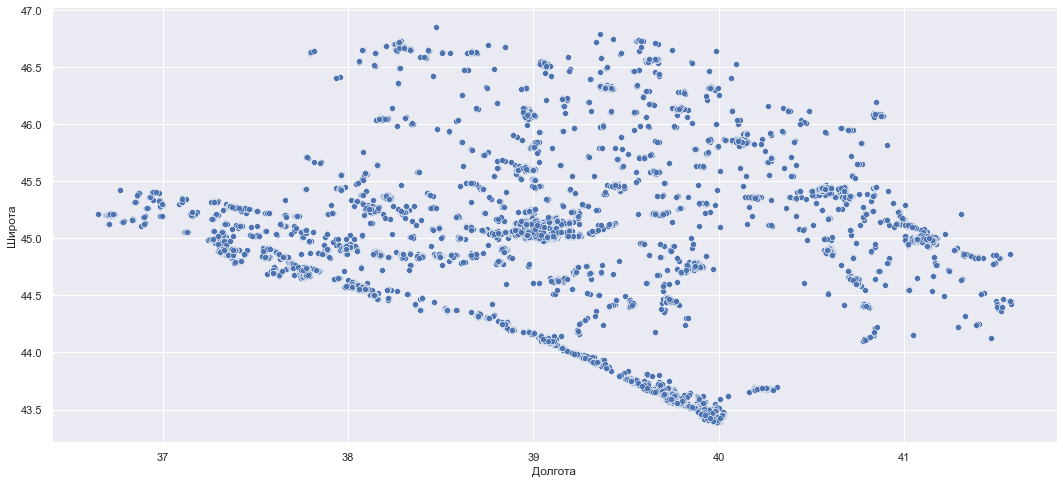

In [227]:
sns.set_theme()
maps = data_krasnodar[['geo_lat','geo_lon']].drop_duplicates()
plt.figure(figsize=(18,8))
sns.scatterplot(maps['geo_lon'],maps['geo_lat'])
plt.xlabel('Долгота')
plt.ylabel('Широта');
#распеределение районов застройки по краснодарскому краю

In [228]:
data_krasnodar

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr
3,1850000,44.99613,39.07478,4,12,16,38.0,5.0,11,2018,3,110.763732,1.742063,False,False
19,1650000,44.99430,41.12281,3,5,5,51.0,7.0,1,2018,3,472.563100,410.392744,True,False
32,2500000,43.63469,39.72717,2,2,8,25.0,5.0,1,2018,4,2.095738,2.095738,False,False
46,2600000,45.00317,39.07993,4,3,5,46.0,8.0,1,2018,4,112.414921,1.601357,True,False
50,2220000,45.00258,39.08318,3,2,18,49.5,16.4,1,2018,4,112.340441,1.515465,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.72070,37.76231,2,18,22,42.0,16.0,1,2021,5,11.677513,11.677513,False,False
5476930,7500000,44.89504,37.31633,2,16,17,44.0,14.0,11,2021,5,1.032282,1.032282,False,True
5476943,2700000,45.10243,39.03398,2,8,17,34.0,10.0,1,2021,5,135.032264,4.224238,False,False
5476990,5800000,45.08555,39.04463,2,1,16,61.0,12.0,11,2021,5,131.026296,3.492078,False,True


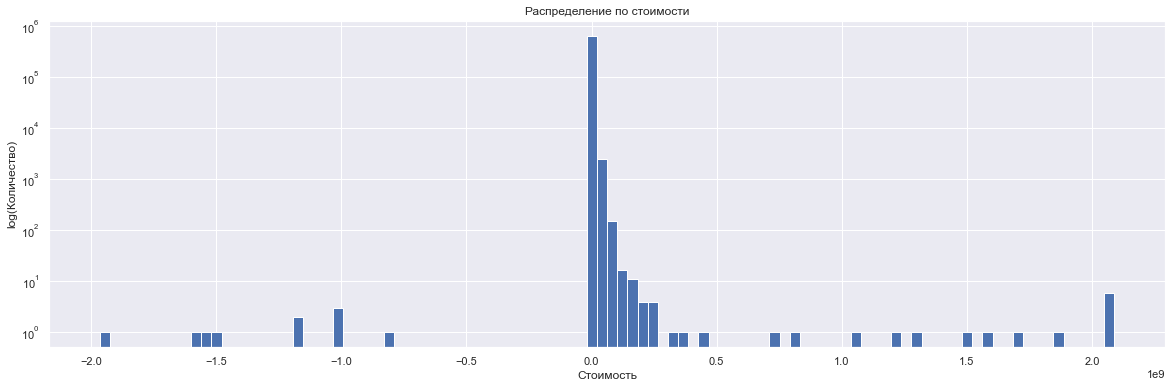

In [229]:
plt.figure(figsize=(20,6))
plt.hist(data_krasnodar.price, bins=100, log=True)
plt.title("Распределение по стоимости")
plt.xlabel('Стоимость')
plt.ylabel('log(Количество)');

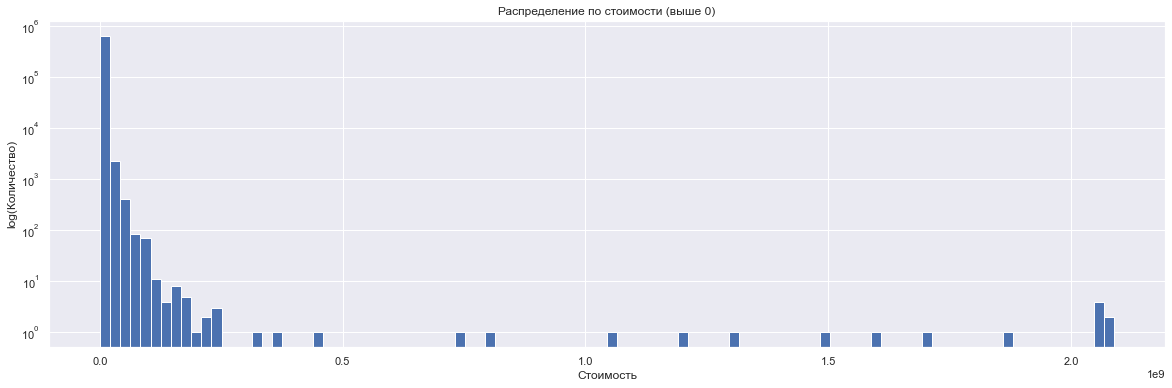

In [230]:
#уберем отрицательные значения
data_krasnodar=data_krasnodar[data_krasnodar.price>0]
plt.figure(figsize=(20,6))
plt.hist(data_krasnodar.price, bins=100, log=True)
plt.title("Распределение по стоимости (выше 0)")
plt.xlabel('Стоимость')
plt.ylabel('log(Количество)');

In [231]:
#рассмотрим участок набиолее часто встречающихся цен

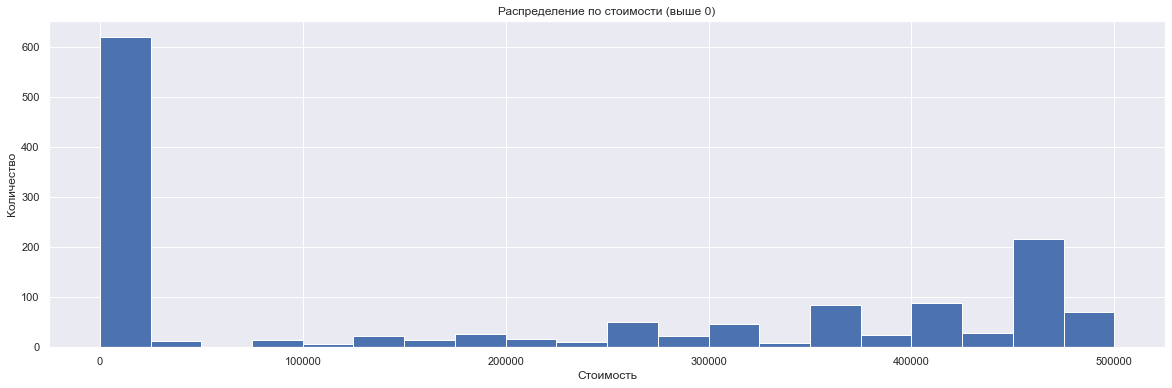

In [232]:
plt.figure(figsize=(20,6))
plt.hist(data_krasnodar[data_krasnodar['price']<500000]['price'], bins=20, log=False)
plt.title("Распределение по стоимости (выше 0)")
plt.xlabel('Стоимость')
plt.ylabel('Количество');

In [233]:
data_krasnodar=data_krasnodar[data_krasnodar['price']>500000]

In [234]:
#очень много недвижимости, которая продается за менее чем 100 т.р

In [235]:
#давайте расссмотрим рынок недвижимости, которая дороже 100 млн рублей

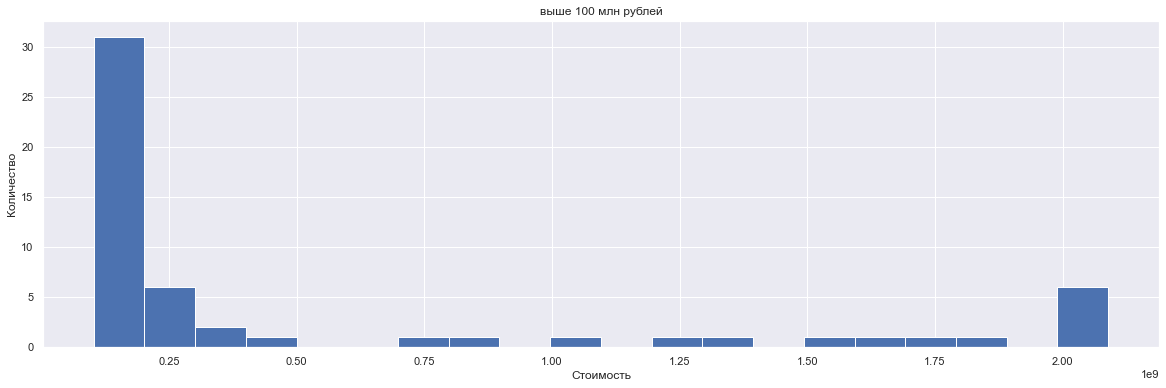

In [236]:
plt.figure(figsize=(20,6))
plt.hist(data_krasnodar[data_krasnodar['price']>100000000]['price'], bins=20, log=False)
plt.title("выше 100 млн рублей")
plt.xlabel('Стоимость')
plt.ylabel('Количество');

In [237]:
data_krasnodar=data_krasnodar[data_krasnodar['price']<50000000]

In [238]:
data_krasnodar

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr
3,1850000,44.99613,39.07478,4,12,16,38.0,5.0,11,2018,3,110.763732,1.742063,False,False
19,1650000,44.99430,41.12281,3,5,5,51.0,7.0,1,2018,3,472.563100,410.392744,True,False
32,2500000,43.63469,39.72717,2,2,8,25.0,5.0,1,2018,4,2.095738,2.095738,False,False
46,2600000,45.00317,39.07993,4,3,5,46.0,8.0,1,2018,4,112.414921,1.601357,True,False
50,2220000,45.00258,39.08318,3,2,18,49.5,16.4,1,2018,4,112.340441,1.515465,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.72070,37.76231,2,18,22,42.0,16.0,1,2021,5,11.677513,11.677513,False,False
5476930,7500000,44.89504,37.31633,2,16,17,44.0,14.0,11,2021,5,1.032282,1.032282,False,True
5476943,2700000,45.10243,39.03398,2,8,17,34.0,10.0,1,2021,5,135.032264,4.224238,False,False
5476990,5800000,45.08555,39.04463,2,1,16,61.0,12.0,11,2021,5,131.026296,3.492078,False,True


In [60]:
print('Медианное значение стоимости недвижимости (более 100 тыс.руб.)', data_krasnodar.price.median())
f_price = 100000
count_price_top = []
for price_i in [2*10**5,3*10**5, 4*10**5, 10**6,5*10**6,10**7,5*10**7,10**8,5*10**8,10**9,5*10**9]:
    print(f'Количество объявлений с ценой {f_price}-{price_i} руб:',data_krasnodar[(data_krasnodar.price > f_price) & (data_krasnodar.price < price_i)]['price'].shape[0])
    f_price = price_i+1
    count_price_top.append(data_krasnodar[(data_krasnodar.price > f_price) & (data_krasnodar.price < price_i)]['price'].shape[0])

Медианное значение стоимости недвижимости (более 100 тыс.руб.) 2800000.0
Количество объявлений с ценой 100000-200000 руб: 55
Количество объявлений с ценой 200001-300000 руб: 101
Количество объявлений с ценой 300001-400000 руб: 132
Количество объявлений с ценой 400001-1000000 руб: 12115
Количество объявлений с ценой 1000001-5000000 руб: 524366
Количество объявлений с ценой 5000001-10000000 руб: 75272
Количество объявлений с ценой 10000001-50000000 руб: 16954
Количество объявлений с ценой 50000001-100000000 руб: 272
Количество объявлений с ценой 100000001-500000000 руб: 40
Количество объявлений с ценой 500000001-1000000000 руб: 2
Количество объявлений с ценой 1000000001-5000000000 руб: 13


In [61]:
y_train,y_test=train_test_split(data_krasnodar.price)

In [239]:
y_pred = [y_train.mean()] * len(y_test)

print("Mean Price", y_train.mean())
print('Baseline MAE', mean_absolute_error(y_test, y_pred))
print('Baseline MSE', mean_squared_error(y_test, y_pred))
print('Baseline R2', r2_score(y_test,y_pred)) 

Mean Price 3590060.4639652367
Baseline MAE 1749842.1323896418
Baseline MSE 43775726958661.15
Baseline R2 -2.8912894296517777e-06


In [240]:
base_df = data_krasnodar.copy()
#Объединение и преобразование даты и времени в datatime. Удаление столбца time 
print(base_df.shape)

#target & data
base_y = base_df['price'] #<-- target
base_x = base_df.drop('price', axis=1) #<-- data

#train & validation
x_train, x_test, y_train, y_test = train_test_split(base_x, base_y, test_size=0.3,random_state=25,)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(635076, 15)


((444553, 14), (190523, 14), (444553,), (190523,))

In [241]:
y_pred = [y_train.mean()] * len(y_train)

print("Mean Price", y_train.mean())
print('Baseline MAE', mean_absolute_error(y_train, y_pred))
print('Baseline MSE', mean_squared_error(y_train, y_pred))
print('Baseline R2', r2_score(y_train,y_pred)) 

Mean Price 3512770.5009841346
Baseline MAE 1646414.6747629242
Baseline MSE 8002752727098.137
Baseline R2 0.0


In [242]:
#линейная регрессия

In [243]:
model_ln = LinearRegression()
model_ln.fit(x_train, y_train)

y_predict_ln = model_ln.predict(x_train)
y_predict_ln_test = model_ln.predict(x_test)

In [244]:
#ridge

In [245]:
model_rdg = Ridge()
model_rdg.fit(x_train, y_train)

y_predict_rdg = model_rdg.predict(x_train)
y_predict_rdg_test = model_rdg.predict(x_test)

In [246]:
#random forest

In [247]:
model_rf = RandomForestRegressor(max_depth=4,random_state=25)
n_jobs=-1
model_rf.fit(x_train, y_train)

y_predict_rf = model_rf.predict(x_train)
y_predict_rf_test = model_rf.predict(x_test)

In [248]:
#xgboost

In [249]:
model_xgb = XGBRegressor(random_state=25, n_jobs=-1)
model_xgb.fit(x_train, y_train)

y_predict_xgb = model_xgb.predict(x_train)
y_predict_xgb_test = model_xgb.predict(x_test)

In [250]:
#Расчет метрики
def metrics(y_predict_train, y_predict_test):
  print('Training data MAE', mean_absolute_error(y_train,y_predict_train))
  print('Validation data MAE', mean_absolute_error(y_test, y_predict_test))
  print('Training data MSE', mean_squared_error(y_train,y_predict_train))
  print('Validation data MSE', mean_squared_error(y_test, y_predict_test))
  print('Validation data MAPE', mean_absolute_percentage_error(y_test, y_predict_test))  
  print('Training data MAPE', mean_absolute_percentage_error(y_train, y_predict_train))  
  print('Training data R2', r2_score(y_train,y_predict_train))
  print('Validation data R2', r2_score(y_test, y_predict_test))
    

In [251]:
#Linear Regression
metrics(y_predict_ln, y_predict_ln_test)

Training data MAE 1009368.842139024
Validation data MAE 1008299.1256512234
Training data MSE 4379305134799.2734
Validation data MSE 4463014916919.645
Validation data MAPE 0.31921500640669254
Training data MAPE 0.3179021043033838
Training data R2 0.45277515323314943
Validation data R2 0.43780842997705993


In [252]:
#Ridge
metrics(y_predict_rdg, y_predict_rdg_test)

Training data MAE 1009364.0616981096
Validation data MAE 1008294.2482667484
Training data MSE 4379305139643.674
Validation data MSE 4463014293647.7705
Validation data MAPE 0.31921267687590316
Training data MAPE 0.3178998804355588
Training data R2 0.45277515262780765
Validation data R2 0.4378085084886043


In [253]:
#Random Forest Regressor
metrics(y_predict_rf, y_predict_rf_test)

Training data MAE 975117.3337162925
Validation data MAE 973164.2216518295
Training data MSE 3054533867522.6255
Validation data MSE 3037042389879.789
Validation data MAPE 0.31095285496268765
Training data MAPE 0.3110333446554193
Training data R2 0.6183146010272613
Validation data R2 0.6174335821913002


In [254]:
#XGBoost Regression
metrics(y_predict_xgb, y_predict_xgb_test)

Training data MAE 714005.8000415058
Validation data MAE 713992.5099694738
Training data MSE 2004928800491.404
Validation data MSE 2006535028977.1406
Validation data MAPE 0.21035213254814827
Training data MAPE 0.2106280967826905
Training data R2 0.7494701049924346
Validation data R2 0.7472432650919157


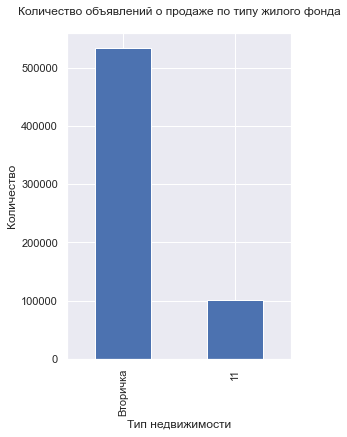

In [255]:
obj_type = data_krasnodar.groupby('object_type')['area'].count()
obj_type.rename(index={1:'Вторичка',2:"Новостройка"}, inplace=True)

plt.figure(figsize=(4,6))
obj_type.plot.bar(y=obj_type.index, x=obj_type, )
plt.title("Количество объявлений о продаже по типу жилого фонда\n")
plt.xlabel('Тип недвижимости')
plt.ylabel('Количество');

In [256]:
#добавим категориальный признак панельности дома, поскрльку местные жители не жалуют панельные дома

In [257]:
data_krasnodar['panel']=data_krasnodar.building_type==1

In [258]:
data_krasnodar[['village','hi_incr','panel']]=data_krasnodar[['village','hi_incr','panel']].astype('int')

In [259]:
data_krasnodar

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr,panel
3,1850000,44.99613,39.07478,4,12,16,38.0,5.0,11,2018,3,110.763732,1.742063,0,0,0
19,1650000,44.99430,41.12281,3,5,5,51.0,7.0,1,2018,3,472.563100,410.392744,1,0,0
32,2500000,43.63469,39.72717,2,2,8,25.0,5.0,1,2018,4,2.095738,2.095738,0,0,0
46,2600000,45.00317,39.07993,4,3,5,46.0,8.0,1,2018,4,112.414921,1.601357,1,0,0
50,2220000,45.00258,39.08318,3,2,18,49.5,16.4,1,2018,4,112.340441,1.515465,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.72070,37.76231,2,18,22,42.0,16.0,1,2021,5,11.677513,11.677513,0,0,0
5476930,7500000,44.89504,37.31633,2,16,17,44.0,14.0,11,2021,5,1.032282,1.032282,0,1,0
5476943,2700000,45.10243,39.03398,2,8,17,34.0,10.0,1,2021,5,135.032264,4.224238,0,0,0
5476990,5800000,45.08555,39.04463,2,1,16,61.0,12.0,11,2021,5,131.026296,3.492078,0,1,0


In [260]:
data_krasnodar_increase_price=data_krasnodar.groupby('hi_incr').price.mean()

In [261]:
data_krasnodar_increase_price=pd.DataFrame(data_krasnodar_increase_price).reset_index()

<AxesSubplot:xlabel='hi_incr', ylabel='price'>

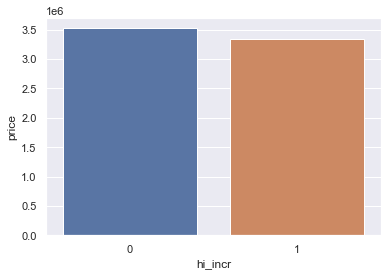

In [262]:
# дома в более густо населнный районах стоят дороже
sns.barplot(x='hi_incr',y='price',data=data_krasnodar_increase_price)

In [263]:
data_krasnodar_increase_count=data_krasnodar.groupby('hi_incr')['area'].count()

In [264]:
data_krasnodar_increase_count=pd.DataFrame(data_krasnodar_increase_count).reset_index()

<AxesSubplot:xlabel='hi_incr', ylabel='area'>

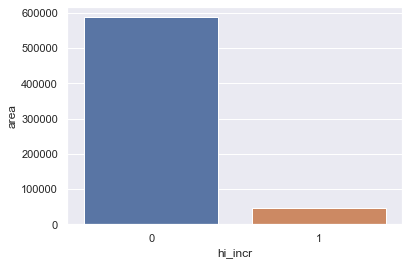

In [265]:
sns.barplot(x='hi_incr',y='area',data=data_krasnodar_increase_count)
# домов в густо населенных районах больше

In [266]:
data_krasnodar_vil_price=data_krasnodar.groupby('village').price.mean()
data_krasnodar_vil_price=pd.DataFrame(data_krasnodar_vil_price).reset_index()

<AxesSubplot:xlabel='village', ylabel='price'>

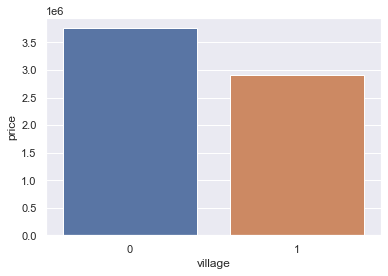

In [267]:
#квартиры в домах не выше 5-ти этажей стоят меньше в среднем на 1 млн
sns.barplot(x='village',y='price',data=data_krasnodar_vil_price)

In [268]:
data_krasnodar_vil_count=data_krasnodar.groupby('village').area.count()
data_krasnodar_vil_count=pd.DataFrame(data_krasnodar_vil_count).reset_index()

<AxesSubplot:xlabel='village', ylabel='area'>

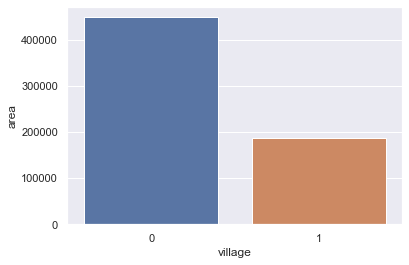

In [269]:
#в более выысоких домах продают больше квартир
sns.barplot(x='village',y='area',data=data_krasnodar_vil_count)

In [270]:
data_krasnodar_pan_price=data_krasnodar.groupby('panel').price.mean()
data_krasnodar_pan_price=pd.DataFrame(data_krasnodar_pan_price).reset_index()

<AxesSubplot:xlabel='panel', ylabel='price'>

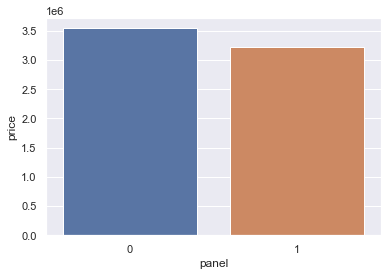

In [271]:
#в панельных домах квартиры стоят дешевле
sns.barplot(x='panel',y='price',data=data_krasnodar_pan_price)

In [272]:
data_krasnodar_pan_count=data_krasnodar.groupby('panel').area.count()
data_krasnodar_pan_count=pd.DataFrame(data_krasnodar_pan_count).reset_index()

<AxesSubplot:xlabel='panel', ylabel='area'>

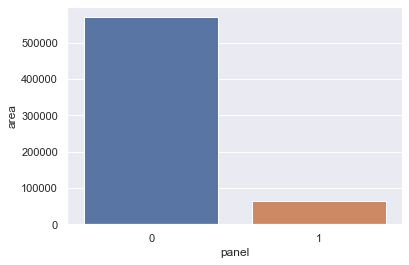

In [273]:
#в панельных домах продается гораздо меньше квартир
sns.barplot(x='panel',y='area',data=data_krasnodar_pan_count)

In [274]:
#Несовпадение по этажу жилья и этажности дома
print('Количество объектов с несовпадениями',len(data_krasnodar[(data_krasnodar.level > data_krasnodar.levels)]))
data_krasnodar[(data_krasnodar.level > data_krasnodar.levels)].head()

Количество объектов с несовпадениями 159


,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr,panel
164863,1050000,45.26109,37.44544,4,2,1,54.0,10.0,1,2018,9,25.947543,25.947543,1,0,0
200249,1200000,45.36432,38.21252,3,2,1,77.0,7.0,1,2018,10,87.935245,87.935245,1,0,0
212292,2100000,45.14295,38.99467,1,7,5,56.0,9.0,1,2018,10,145.005698,6.948050,1,0,1
214610,2800000,45.13763,38.99603,1,14,13,62.0,12.0,1,2018,10,143.658628,6.720654,0,0,1
235492,2150000,45.05400,39.02581,1,16,8,47.0,11.0,1,2018,10,123.386304,3.691807,0,1,1


In [275]:
# Меняем местами перепутанные значения 'level' и 'levels'
level_indx = data_krasnodar[(data_krasnodar.level > data_krasnodar.levels)].index

for lev in level_indx:
    if data_krasnodar.level.loc[lev] > data_krasnodar.levels.loc[lev]:
        data_krasnodar.level.loc[lev], data_krasnodar.levels.loc[lev] = data_krasnodar.levels.loc[lev], data_krasnodar.level.loc[lev]

/Users/mihailkozlov/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [276]:
#Несовпадение по этажу жилья и этажности дома
print('Количество объектов с несовпадениями',len(data_krasnodar[(data_krasnodar.level > data_krasnodar.levels)]))
data_krasnodar[(data_krasnodar.level > data_krasnodar.levels)].head()

Количество объектов с несовпадениями 0


,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr,panel


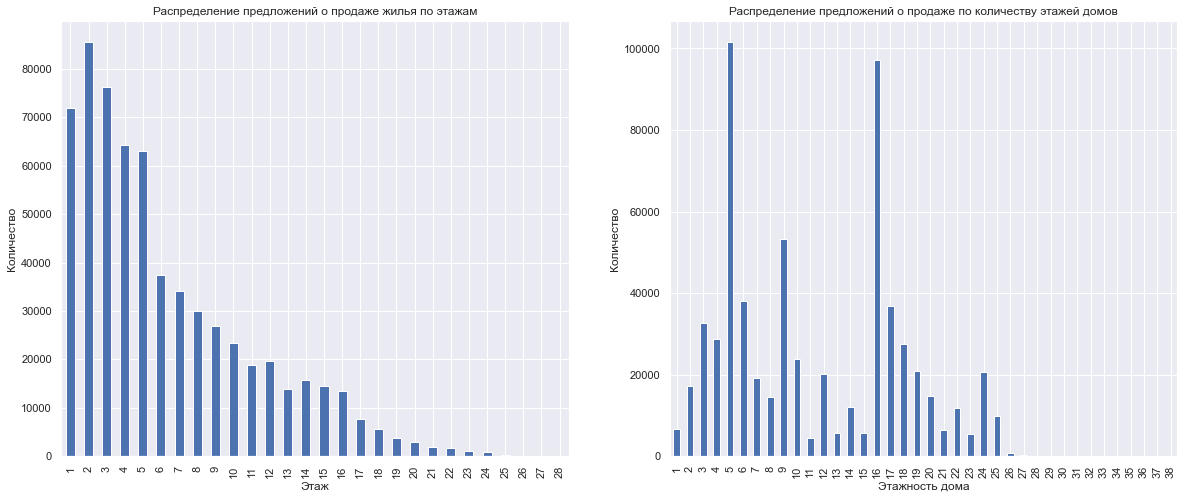

In [277]:
lev = data_krasnodar.groupby('level')['level'].count()
levs = data_krasnodar.groupby('levels')['levels'].count()

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
lev.plot.bar(x=lev.index, y=lev)
plt.title("Распределение предложений о продаже жилья по этажам")
plt.xlabel('Этаж')
plt.ylabel('Количество')

plt.subplot(1,2,2)
levs.plot.bar(x=levs.index, y=levs)
plt.title("Распределение предложений о продаже по количеству этажей домов")
plt.xlabel('Этажность дома')
plt.ylabel('Количество');

In [278]:
#Замена типа данных 
data_krasnodar = data_krasnodar.astype({'level':'int8','levels':'int8'})

In [279]:
print('Количество объектов по которым площадь кухни больше общей площади',len(data_krasnodar[(data_krasnodar.kitchen_area > data_krasnodar.area)]))
data_krasnodar[(data_krasnodar.kitchen_area > data_krasnodar.area)].head()

Количество объектов по которым площадь кухни больше общей площади 434


,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr,panel
23748,690000,44.63886,40.72546,3,1,1,21.0,27.0,1,2018,9,260.691684,260.691684,1,0,0
64004,1930000,45.08606,39.01445,3,1,3,65.0,85.0,1,2018,9,130.950609,4.643575,1,0,0
103524,600000,45.36344,40.66741,3,4,5,28.0,100.0,1,2018,9,489.321788,253.677757,1,0,0
221465,2900000,45.04016,38.97596,1,3,9,34.8,98.0,1,2018,10,120.158760,5.750319,0,1,1
289002,900000,45.01866,38.98194,3,2,2,18.0,32.0,1,2018,10,115.217136,5.316569,1,0,0


In [280]:
#поменяем местами площадь кухни и общую площадь

In [281]:
for a in data_krasnodar[(data_krasnodar.kitchen_area > data_krasnodar.area)].index:
    if data_krasnodar.kitchen_area[a] > data_krasnodar.area[a]:
        data_krasnodar.kitchen_area.loc[a], data_krasnodar.area.loc[a] = data_krasnodar.area.loc[a], data_krasnodar.kitchen_area.loc[a]

/Users/mihailkozlov/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [282]:
print('Количество объектов по которым площадь кухни больше общей площади',len(data_krasnodar[(data_krasnodar.kitchen_area > data_krasnodar.area)]))

Количество объектов по которым площадь кухни больше общей площади 0


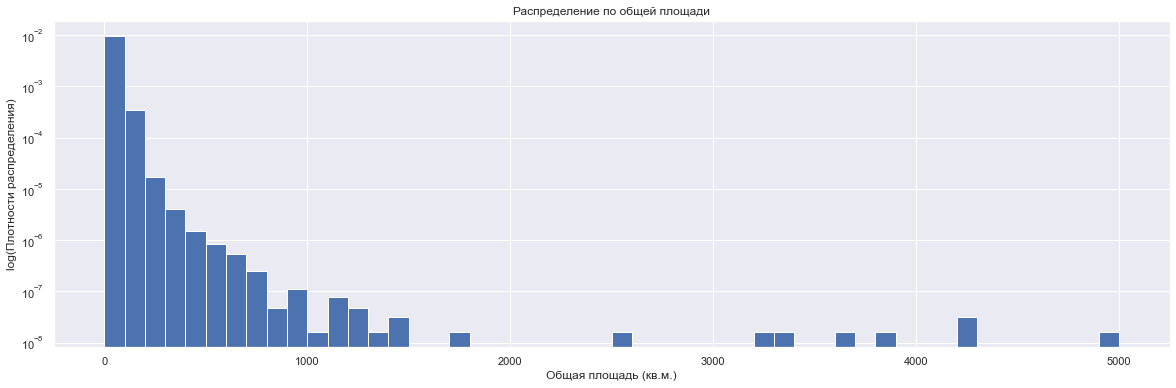

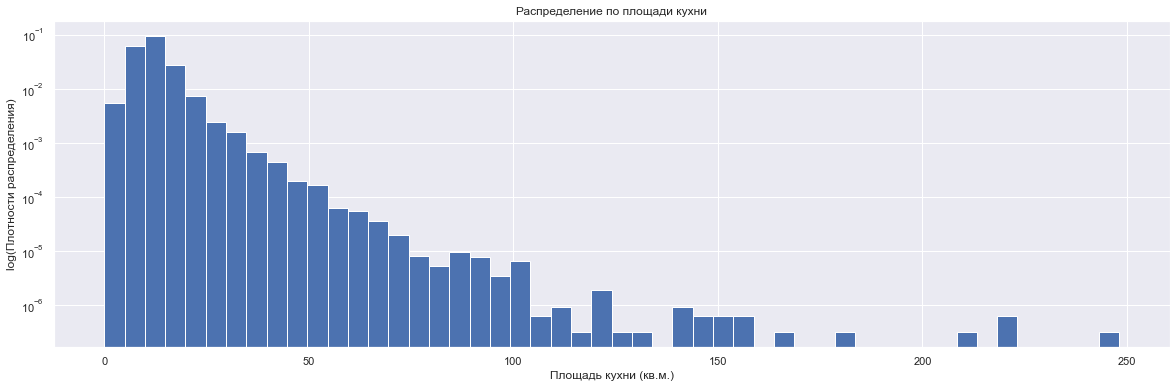

In [286]:
plt.figure(figsize=(20,6))
plt.hist(data_krasnodar.area, bins = 50, density=True, stacked=True, log=True)
plt.title("Распределение по общей площади")
plt.xlabel('Общая площадь (кв.м.)')
plt.ylabel('log(Плотности распределения)')
plt.show()

plt.figure(figsize=(20,6))
plt.hist(data_krasnodar.kitchen_area, bins = 50, density=True, stacked=True, log=True)
plt.title("Распределение по площади кухни")
plt.xlabel('Площадь кухни (кв.м.)')
plt.ylabel('log(Плотности распределения)')
plt.show()

In [284]:
#ограничим выборку, чтобы не было выбросов

In [285]:
#Удаляем записи, в которых площадь кухни больше 500 кв.м.
data_krasnodar = data_krasnodar[data_krasnodar['kitchen_area']<500]

#Удаляем записи, в которых площадь дома больше 6000 кв.м.
data_krasnodar = data_krasnodar[data_krasnodar['area']<6000]

In [287]:
# Удаляем все, что ниже 9 кв.м. общей площади
data_geo = data_krasnodar[data_krasnodar['area'] >= 9]
data_geo.shape

(633699, 16)

In [288]:
if data[data.kitchen_area == 0].shape[0] == 0:
    print('Вся недвижимость имеет кухни. Отсюда вывод: все помещения жилые!')
else:
    print(f'Хм, есть недвижимость без кухонь. Их ровно {data[data.kitchen_area == 0].shape[0]}. Датасет содержит не только жилые помещения, или это выбросы?')

Вся недвижимость имеет кухни. Отсюда вывод: все помещения жилые!


Text(0, 0.5, 'Количество объявлений')

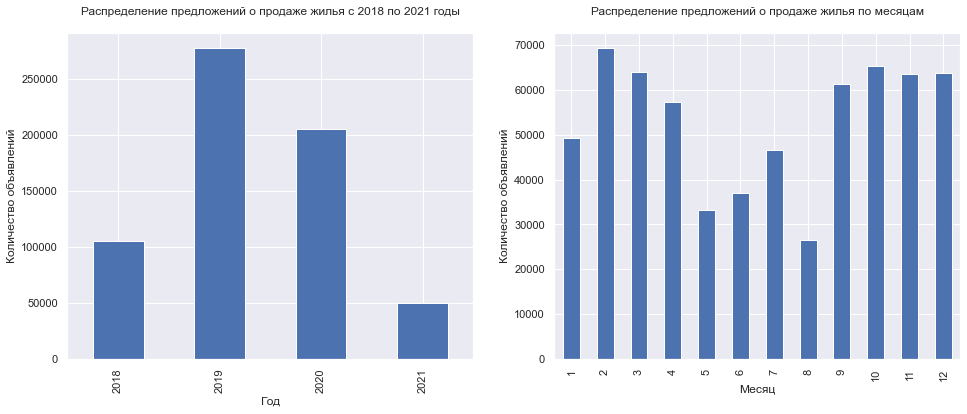

In [454]:
year = data_krasnodar.groupby('year')['year'].count()
mon = data_krasnodar.groupby('month')['month'].count()

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
year.plot.bar(x=year.index, y=year)
plt.title("Распределение предложений о продаже жилья c 2018 по 2021 годы\n")
plt.xlabel('Год')
plt.ylabel('Количество объявлений')

plt.subplot(1,2,2)
mon.plot.bar(x=mon.index, y=mon)
plt.title("Распределение предложений о продаже жилья по месяцам\n")
plt.xlabel('Месяц')
plt.ylabel('Количество объявлений')

In [455]:
#Максимальное предложение отмечаются в 2019 и 2020г. Стоит отметить что данные по 2021г. неполные (в выборке были данные по апрель, вроде). 
#По месяцам распределение равномерное, немного проседают в летние месяцы (с мая), а также в январе

In [289]:
#Можно добавить признак - сезон
data_krasnodar['season'] = data_krasnodar['month']
data_krasnodar['season'] = data_krasnodar['season'].replace({1:1,2:1,3:2,4:2,5:2,6:3,7:3,8:3,9:4,10:4,11:4,12:1})

Text(0, 0.5, 'Количество объявлений')

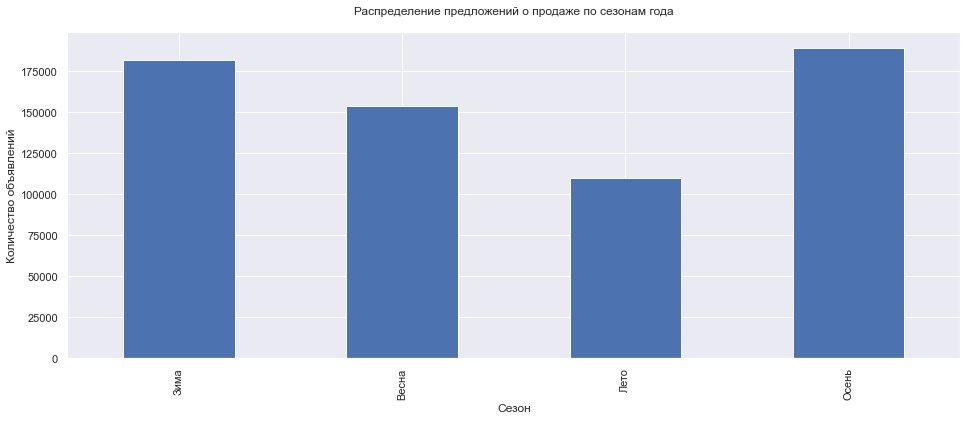

In [290]:
season = data_krasnodar.groupby('season')['season'].count()
season.rename(index={1:'Зима', 2:"Весна", 3:"Лето", 4:"Осень"}, inplace=True)
plt.figure(figsize=(16,6))
season.plot.bar(x=season.index, y=season,)
plt.title("Распределение предложений о продаже по сезонам года\n")
plt.xlabel('Сезон')
plt.ylabel('Количество объявлений')

In [291]:
data_krasnodar2 = data_krasnodar.copy()
print(data_krasnodar2.shape)

#target & data
base_y = data_krasnodar2['price'] #<-- target
base_x = data_krasnodar2.drop('price', axis=1) #<-- data

#train & validation
x_train, x_test, y_train, y_test = train_test_split(base_x, base_y, test_size=0.3,random_state=25,)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(635073, 17)


((444551, 16), (190522, 16), (444551,), (190522,))

In [292]:
data_krasnodar2

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr,panel,season
3,1850000,44.99613,39.07478,4,12,16,38.0,5.0,11,2018,3,110.763732,1.742063,0,0,0,2
19,1650000,44.99430,41.12281,3,5,5,51.0,7.0,1,2018,3,472.563100,410.392744,1,0,0,2
32,2500000,43.63469,39.72717,2,2,8,25.0,5.0,1,2018,4,2.095738,2.095738,0,0,0,2
46,2600000,45.00317,39.07993,4,3,5,46.0,8.0,1,2018,4,112.414921,1.601357,1,0,0,2
50,2220000,45.00258,39.08318,3,2,18,49.5,16.4,1,2018,4,112.340441,1.515465,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.72070,37.76231,2,18,22,42.0,16.0,1,2021,5,11.677513,11.677513,0,0,0,2
5476930,7500000,44.89504,37.31633,2,16,17,44.0,14.0,11,2021,5,1.032282,1.032282,0,1,0,2
5476943,2700000,45.10243,39.03398,2,8,17,34.0,10.0,1,2021,5,135.032264,4.224238,0,0,0,2
5476990,5800000,45.08555,39.04463,2,1,16,61.0,12.0,11,2021,5,131.026296,3.492078,0,1,0,2


In [293]:
#LinearRegression
model_ln = LinearRegression()
model_ln.fit(x_train, y_train)

y_predict_ln = model_ln.predict(x_train)
y_predict_ln_test = model_ln.predict(x_test)

metrics(y_predict_ln, y_predict_ln_test)

Training data MAE 1015801.8922216229
Validation data MAE 1015921.1449388796
Training data MSE 3992756654674.4116
Validation data MSE 3978533407492.2964
Validation data MAPE 0.3260938319531399
Training data MAPE 0.32541361999876306
Training data R2 0.5005592481334296
Validation data R2 0.5000621136760632


In [294]:
#target & data
y = data_geo['price'] #<-- target
X = data_geo.drop('price', axis=1) #<-- data

#train & validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=25,)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((443589, 15), (190110, 15), (443589,), (190110,))

In [295]:
#Для проверки 
x_train1 = X_train.copy()
x_test1 = X_test.copy()

x_train1.shape, x_test1.shape, y_train.shape, y_test.shape

((443589, 15), (190110, 15), (443589,), (190110,))

In [296]:
model_ln = LinearRegression()
model_ln.fit(x_train1, y_train)

y_predict_ln = model_ln.predict(x_train1)
y_predict_ln_test = model_ln.predict(x_test1)

In [297]:
model_xgb = XGBRegressor(random_state=25, n_jobs=-1)
model_xgb.fit(x_train1, y_train)

y_predict_xgb = model_xgb.predict(x_train1)
y_predict_xgb_test = model_xgb.predict(x_test1)

In [298]:
metrics(y_predict_ln, y_predict_ln_test)

Training data MAE 1023987.4371654231
Validation data MAE 1017816.6224793262
Training data MSE 4008149296311.3984
Validation data MSE 3923519190444.764
Validation data MAPE 0.32518025324571137
Training data MAPE 0.3278985626126533
Training data R2 0.4965455903518359
Validation data R2 0.5135927598349437


In [299]:
metrics(y_predict_ln, y_predict_ln_test)

Training data MAE 1023987.4371654231
Validation data MAE 1017816.6224793262
Training data MSE 4008149296311.3984
Validation data MSE 3923519190444.764
Validation data MAPE 0.32518025324571137
Training data MAPE 0.3278985626126533
Training data R2 0.4965455903518359
Validation data R2 0.5135927598349437


In [300]:
metrics(y_predict_xgb, y_predict_xgb_test)

Training data MAE 714399.1536926725
Validation data MAE 715380.1345448031
Training data MSE 2007147912472.6738
Validation data MSE 2085495797092.0188
Validation data MAPE 0.21010211044585372
Training data MAPE 0.21050207953832784
Training data R2 0.7478867695171882
Validation data R2 0.7414565328214026


In [301]:
metrics(y_predict_xgb, y_predict_xgb_test)

Training data MAE 714399.1536926725
Validation data MAE 715380.1345448031
Training data MSE 2007147912472.6738
Validation data MSE 2085495797092.0188
Validation data MAPE 0.21010211044585372
Training data MAPE 0.21050207953832784
Training data R2 0.7478867695171882
Validation data R2 0.7414565328214026


In [302]:
data_krasnodar

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr,panel,season
3,1850000,44.99613,39.07478,4,12,16,38.0,5.0,11,2018,3,110.763732,1.742063,0,0,0,2
19,1650000,44.99430,41.12281,3,5,5,51.0,7.0,1,2018,3,472.563100,410.392744,1,0,0,2
32,2500000,43.63469,39.72717,2,2,8,25.0,5.0,1,2018,4,2.095738,2.095738,0,0,0,2
46,2600000,45.00317,39.07993,4,3,5,46.0,8.0,1,2018,4,112.414921,1.601357,1,0,0,2
50,2220000,45.00258,39.08318,3,2,18,49.5,16.4,1,2018,4,112.340441,1.515465,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.72070,37.76231,2,18,22,42.0,16.0,1,2021,5,11.677513,11.677513,0,0,0,2
5476930,7500000,44.89504,37.31633,2,16,17,44.0,14.0,11,2021,5,1.032282,1.032282,0,1,0,2
5476943,2700000,45.10243,39.03398,2,8,17,34.0,10.0,1,2021,5,135.032264,4.224238,0,0,0,2
5476990,5800000,45.08555,39.04463,2,1,16,61.0,12.0,11,2021,5,131.026296,3.492078,0,1,0,2


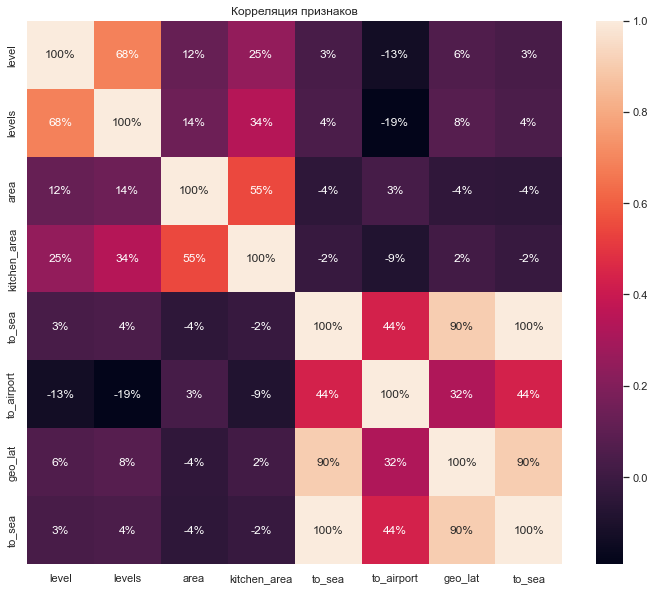

In [303]:
plt.figure(figsize=(12,10))
sns.heatmap(data_krasnodar[['level','levels','area','kitchen_area','to_sea','to_airport','geo_lat','to_sea']].corr(method='spearman'), annot=True,fmt='.0%')
plt.title('Корреляция признаков');

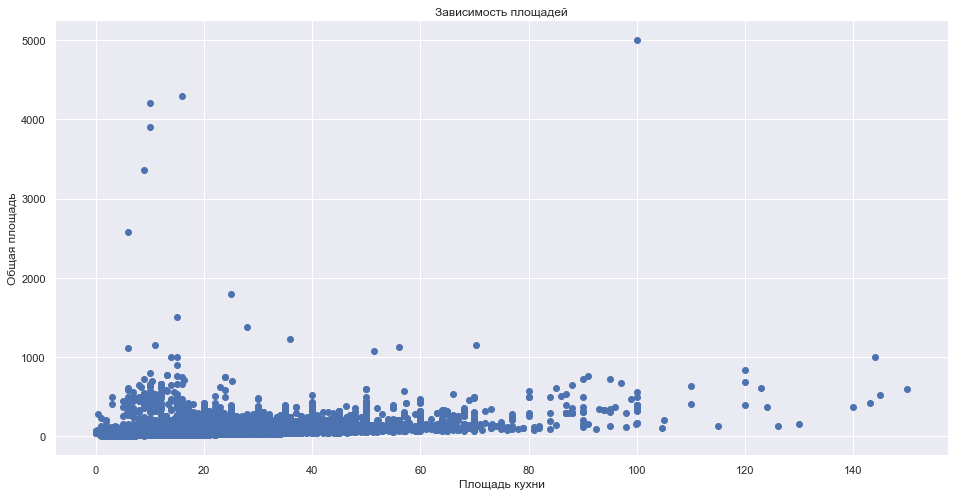

In [306]:
plt.figure(figsize=(16,8))
plt.scatter(X_train.kitchen_area, X_train.area)
plt.title("Зависимость площадей")
plt.xlabel('Площадь кухни')
plt.ylabel('Общая площадь');

In [305]:
#Удаляем значения площади кухни более 150 кв.м.
k_area = X_train[(X_train['kitchen_area']>150)].index
print(k_area.shape)
print(X_train.shape)

X_train.drop(k_area,inplace=True)
print(X_train.shape)

y_train.drop(k_area,inplace=True)
print(y_train.shape)

(7,)
(443589, 15)
(443582, 15)
(443582,)


/Users/mihailkozlov/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [471]:
#Удаляем значения площади более 2300 кв.м.
area = X_train[(X_train['area']>2000)].index
print(area.shape)

X_train.drop(area,inplace=True)
print(X_train.shape)

y_train.drop(area,inplace=True)
print(y_train.shape)

(9,)
(444994, 15)
(444994,)


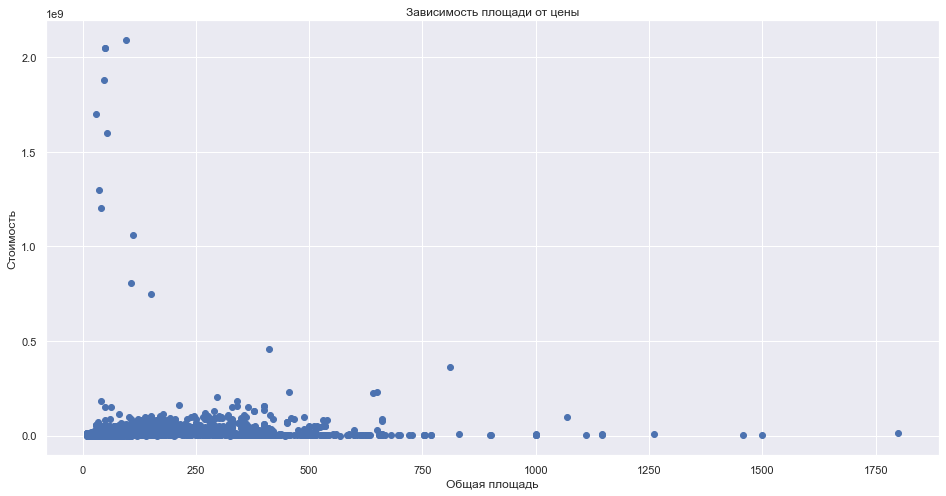

In [472]:
plt.figure(figsize=(16,8))
plt.scatter(X_train.area, (y_train))
plt.title("Зависимость площади от цены")
plt.xlabel('Общая площадь')
plt.ylabel('Стоимость');

In [473]:
#Сократим ещё площадь до 1300 кв.м.
area = X_train[(X_train['area']>800)].index
print(area.shape)

X_train.drop(area,inplace=True)
print(X_train.shape)

y_train.drop(area,inplace=True)
print(y_train.shape)

(16,)
(444978, 15)
(444978,)


In [474]:
#Удалим площади менее 800 кв.м. и стоимостью более 150 млн.руб
a = pd.concat([X_train[(X_train['area']<800)],y_train], join='inner',axis=1)
area2 = a[a['price']>150*10**6].index

print(area2.shape)

X_train.drop(area2,inplace=True)
print(X_train.shape)

y_train.drop(area2,inplace=True)
print(y_train.shape)

(23,)
(444955, 15)
(444955,)


In [475]:
y_train.max()

150000000

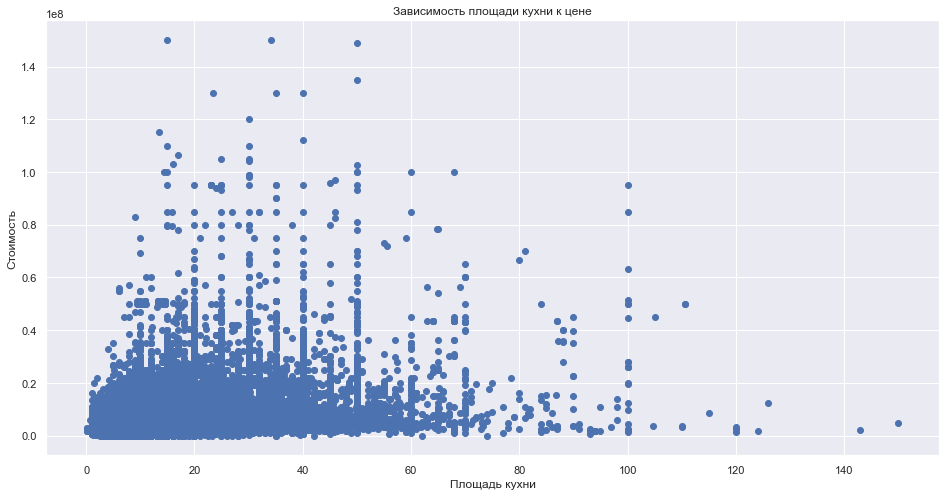

In [476]:
plt.figure(figsize=(16,8))
plt.scatter(X_train.kitchen_area, (y_train))
plt.title("Зависимость площади кухни к цене")
plt.xlabel('Площадь кухни')
plt.ylabel('Стоимость');

In [477]:
#Удалим площадь кухни более 100 кв.м. и стоимостью более 220 млн.руб
a = pd.concat([X_train[X_train['kitchen_area']>100],y_train], join='inner',axis=1)
area2 = a[a['price']>2.2*10**8].index

print(area2.shape)

X_train.drop(area2,inplace=True)
print(X_train.shape)

y_train.drop(area2,inplace=True)
print(y_train.shape)

(0,)
(444955, 15)
(444955,)


In [478]:
#а также площадь кухни более 80 кв.м. и стоимостью более 600 млн.руб
a = pd.concat([X_train[X_train['kitchen_area']>80],y_train], join='inner',axis=1)
area2 = a[a['price']>6*10**8].index

print(area2.shape)

X_train.drop(area2,inplace=True)
print(X_train.shape)

y_train.drop(area2,inplace=True)
print(y_train.shape)

(0,)
(444955, 15)
(444955,)


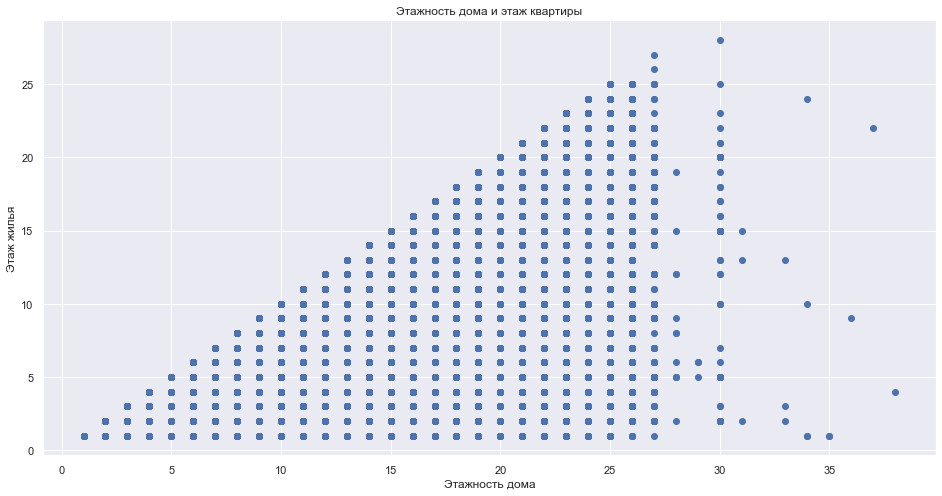

In [479]:
plt.figure(figsize=(16,8))

plt.scatter(X_train.levels, X_train.level)
plt.title("Этажность дома и этаж квартиры")
plt.xlabel('Этажность дома')
plt.ylabel('Этаж жилья');

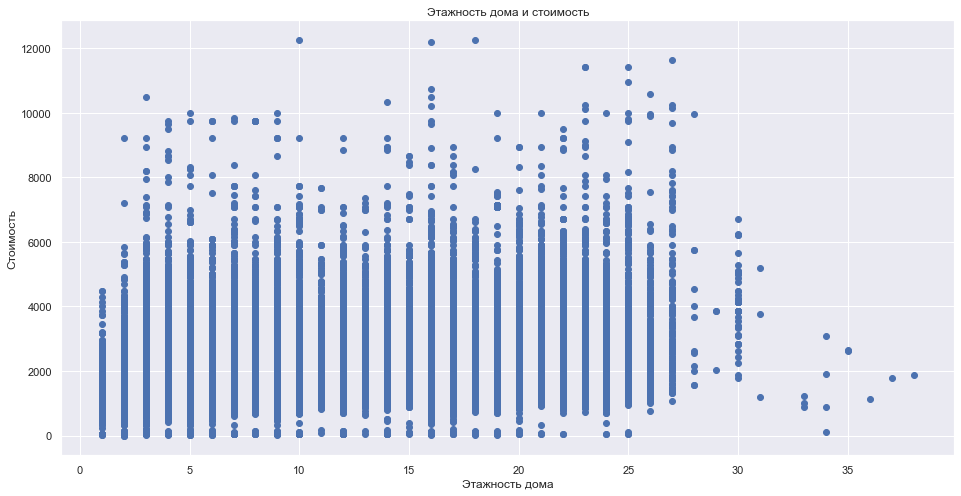

In [480]:
plt.figure(figsize=(16,8))

plt.scatter(X_train.levels, np.sqrt(y_train))
plt.title("Этажность дома и стоимость")
plt.xlabel('Этажность дома')
plt.ylabel('Стоимость');

In [481]:
#Удалим с этажами более 20 и стоимостью более 0,4 млрд.руб.
a = pd.concat([X_train[X_train['levels']>20],y_train], join='inner',axis=1)
levels = a[a['price']>5*(10**8)].index

print(levels.shape)

X_train.drop(levels,inplace=True)
print(X_train.shape)

y_train.drop(levels,inplace=True)
print(y_train.shape)

(0,)
(444955, 15)
(444955,)


In [482]:
XX_train = X_train.copy()
XX_test = X_test.copy()

In [483]:
model_ln = LinearRegression()
model_ln.fit(XX_train, y_train)

y_predict_ln = model_ln.predict(XX_train)
y_predict_ln_test = model_ln.predict(XX_test)

metrics(y_predict_ln, y_predict_ln_test)

Training data MAE 1022767.8926115888
Validation data MAE 1071970.1477107944
Training data MSE 5279030345733.945
Validation data MSE 84877214439128.05
Training data R2 0.5091368614714887
Validation data R2 0.062498608096895114


In [484]:
model_xgb = XGBRegressor(random_state=25, n_jobs=-1)
model_xgb.fit(XX_train, y_train)

y_predict_xgb = model_xgb.predict(XX_train)
y_predict_xgb_test = model_xgb.predict(XX_test)

In [485]:
metrics(y_predict_xgb,y_predict_xgb_test)

Training data MAE 759481.8019156695
Validation data MAE 804291.8573406651
Training data MSE 3323441757857.204
Validation data MSE 82807831547011.53
Training data R2 0.6909744886583538
Validation data R2 0.08535573594398138


In [486]:
data_krasnodar

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr,panel,season
3,1850000,45.0,39.1,4,12,16,38.0,5.0,11,2018,3,110.763732,1.742063,0,1,0,2
19,1650000,45.0,41.1,3,5,5,51.0,7.0,1,2018,3,472.563100,410.392744,1,0,0,2
32,2500000,43.6,39.7,2,2,8,25.0,5.0,1,2018,4,2.095738,2.095738,0,0,0,2
46,2600000,45.0,39.1,4,3,5,46.0,8.0,1,2018,4,112.414921,1.601357,1,1,0,2
50,2220000,45.0,39.1,3,2,18,49.5,16.4,1,2018,4,112.340441,1.515465,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476895,4050000,44.7,37.8,2,18,22,42.0,16.0,1,2021,5,11.677513,11.677513,0,0,0,2
5476930,7500000,44.9,37.3,2,16,17,44.0,14.0,11,2021,5,1.032282,1.032282,0,1,0,2
5476943,2700000,45.1,39.0,2,8,17,34.0,10.0,1,2021,5,135.032264,4.224238,0,1,0,2
5476990,5800000,45.1,39.0,2,1,16,61.0,12.0,11,2021,5,131.026296,3.492078,0,1,0,2


In [487]:
data_krasnodar2.price.mean()

3586688.0457715252

In [488]:
data_krasnodar.price.mean()

3586688.0457715252

In [489]:
data_krasnodar2.mode()

,price,geo_lat,geo_lon,building_type,level,levels,area,kitchen_area,object_type,year,month,to_sea,to_airport,village,hi_incr,panel,season
0,2500000,45.1,39.0,3,2,5,40.0,10.0,1,2019,2,131.026296,3.492078,0,1,0,4


In [491]:
a=RandomizedSearchCV(model_xgb,n_jobs=-1)

TypeError: __init__() missing 1 required positional argument: 'param_distributions'